In [22]:
import pandas as pd
import re
import json
from collections import defaultdict
import numpy as np
import openai
import os
from sklearn.model_selection import train_test_split
import time
from openai import OpenAI

In [3]:
sample = ds.head(2000)

In [2]:
ds = pd.read_csv('kaggle_dataset/twcs/twcs.csv') #, chunksize=chunk_size
print(f"Number of rows in ds: {ds.shape[0]}")

Number of rows in ds: 2811774


In [25]:
os.environ["OPENAI_API_KEY"] = ""

In [5]:
def author_id_frequency_distribution(df):
    """
    Function to get the frequency distribution of author_ids in the dataframe, 
    including only those where author_id is a string and not a numeric string.
    
    Parameters:
    - df (pandas.DataFrame): The dataset of tweets.
    
    Returns:
    - pandas.Series: The frequency distribution of author_id.
    """
    # Filter out rows where author_id is a string and not numeric
    df_filtered = df[df["author_id"].apply(lambda x: isinstance(x, str) and not x.isdigit())]
    
    # Calculate the frequency distribution of author_id
    freq_distribution = df_filtered["author_id"].value_counts()
    
    return freq_distribution


In [6]:
author_id_frequency_distribution(ds)

author_id
AmazonHelp        169840
AppleSupport      106860
Uber_Support       56270
SpotifyCares       43265
Delta              42253
                   ...  
JackBox              266
OfficeSupport        218
AskDSC               210
CarlsJr              196
HotelTonightCX       152
Name: count, Length: 108, dtype: int64

In [16]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove everything starting with @ (user mentions and company mentions)
    text = re.sub(r'@\S+', '', text)  # This removes all mentions starting with @
    
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    
    # Remove punctuation (except for spaces and alphanumeric characters)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove initials at the end of messages (e.g., "CB", "HP")
    text = re.sub(r'\b[A-Z]{2}\b$', '', text)

    # Normalize spaces (replace multiple spaces with one)
    text = ' '.join(text.split())

    return text

In [11]:
def process_conversations(df, system_message, company_name=None):
    """
    Function to process conversations from a DataFrame.
    
    Parameters:
    - df (pandas.DataFrame): The dataset of tweets.
    - system_message (str): The system message for the assistant.
    - company_name (str): The name of the company to filter conversations (optional).
    
    Returns:
    - List of conversations in the required format.
    """
    
    # Set to track processed tweet IDs
    processed = set()

    conversations = []

    # Iterate through dataset to construct conversations
    for index, row in df.iterrows():
        tweet_id = row["tweet_id"]
        
        # Skip if already processed
        if tweet_id in processed:
            continue
        
        # Start new conversation if it's an inbound message (user) and not a reply
        if row["inbound"] and pd.isna(row["in_response_to_tweet_id"]):
            conversation = [{"role": "system", "content": system_message}]
            queue = [tweet_id]  # Use a queue to process messages in order
            last_message_is_assistant = False  # Flag to check if last message is from assistant
            company_assistant_messages = True  # Track if all assistant messages are from the company

            # Process conversation thread
            while queue:
                current_id = queue.pop(0)

                # Check if current_id exists in df
                if current_id not in df['tweet_id'].values:
                    continue
                
                # Get message details
                message = df[df["tweet_id"] == current_id].iloc[0]
                role = "user" if message["inbound"] else "assistant"
                
                # If company name is provided, filter outbound messages by company author_id
                if company_name and message["inbound"] == False and message["author_id"] != company_name:
                    company_assistant_messages = False  # If any assistant message is not from company, set to False
                    break  # Exit the loop early, as we've found an invalid assistant message
                
                # Add message to conversation
                conversation.append({"role": role, "content": clean_text(message["text"])})
                
                # Check if this message is from the assistant
                if role == "assistant":
                    last_message_is_assistant = True
                else:
                    last_message_is_assistant = False
                
                # Mark as processed
                processed.add(current_id)
                
                # Find all responses to this message
                next_responses = df[df["in_response_to_tweet_id"] == current_id]
                
                if not next_responses.empty:
                    # Add tweet_id of all responses to the queue
                    for _, response in next_responses.iterrows():
                        queue.append(response["tweet_id"])

            if last_message_is_assistant and company_assistant_messages:
                conversations.append(conversation)

    return conversations

In [12]:
def process_in_chunks(df, chunk_size, system_message, company_name=None):
    """
    Process the DataFrame in chunks to get conversations.
    
    Parameters:
    - df (pandas.DataFrame): The dataset of tweets.
    - chunk_size (int): The size of each chunk.
    - system_message (str): The system message for the assistant.
    - company_name (str): The name of the company to filter conversations (optional).
    
    Returns:
    - List of conversations in the required format.
    """
    conversations = []

    chunks = np.array_split(df, len(df) // chunk_size + 1)

    for chunk in chunks:
        print(f"Processing chunk with {len(chunk)} records.")
        chunk_conversations = process_conversations(chunk, system_message, company_name)
        conversations.extend(chunk_conversations)
    
    return conversations

In [13]:
# Example usage
system_message = "You are a polite customer assistant whose goal is to provide effective help."
chunk_size = 50000  # You can adjust the chunk size based on your system's capacity
company_name = 'VirginTrains'

# Assuming `ds` is your dataframe
conversations = process_in_chunks(ds, chunk_size, system_message, company_name)

print(f"Total number of conversations: {len(conversations)}")

Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49330 records.
Processing chunk with 49329 records.
Processing chunk with 49329 records.
Processing chunk with 49329 records.
Processing chunk with 49329 records.
Processing chunk with 49329 records.
Processing chunk with 49329 records.
P

In [17]:
conversations[0:2]

[[{'role': 'system',
   'content': 'You are a polite customer assistant whose goal is to provide effective help.'},
  {'role': 'user',
   'content': 'so i wait almost 3 hours and then they are rude and arrogant amp unhelpful after which she is raising a technical case'},
  {'role': 'assistant',
   'content': 'If youre unhappy with your experience on this call please contact us on our website CB'}],
 [{'role': 'system',
   'content': 'You are a polite customer assistant whose goal is to provide effective help.'},
  {'role': 'user',
   'content': 'Gotta luv finally get 2 call cntr they tried to charge me 176 for a ticket which can b purchased for 88 online'},
  {'role': 'assistant',
   'content': 'When amending a ticket the system would show a fare that matches your previous purchase but this may be higher CB'}]]

In [18]:
def clean_initials(text):
    """Removes two-letter uppercase initials at the end of the assistant's response."""
    return re.sub(r'\b[A-Z]{2}\b$', '', text).strip()

# Iterate and clean assistant responses
for conversation in conversations:
    for message in conversation:
        if message['role'] == 'assistant':
            message['content'] = clean_initials(message['content'])

In [21]:
conversations[3:10]

[[{'role': 'system',
   'content': 'You are a polite customer assistant whose goal is to provide effective help.'},
  {'role': 'user',
   'content': 'Thank you for the advice to make the connection After a long long day it is appreciated'},
  {'role': 'assistant', 'content': 'Happy the team could help'}],
 [{'role': 'system',
   'content': 'You are a polite customer assistant whose goal is to provide effective help.'},
  {'role': 'user', 'content': 'Night Joel'},
  {'role': 'assistant', 'content': 'Good night Becky'}],
 [{'role': 'system',
   'content': 'You are a polite customer assistant whose goal is to provide effective help.'},
  {'role': 'user',
   'content': 'can u confirm how long was the delay for 2043 train from London Euston to Bham New Street on 231117 Train announcer even announced it 45mins late But Im getting reply for my refund claim that it was 9mins Pls ampTq'},
  {'role': 'assistant',
   'content': 'Hi Joanne we have this service reported 1 minute early arriving into

In [20]:
# Save to a JSONL file
output_file = "openai_files/multi_turn_conversation_train.jsonl"

with open(output_file, "w", encoding="utf-8") as file:
    for conversation in conversations:
        file.write(json.dumps(conversation, ensure_ascii=False) + "\n")

print(f"Cleaned conversations saved to {output_file}")

Cleaned conversations saved to multi_turn_conversation_train.jsonl


In [63]:
def split_and_save_conversations(conversations, train_filename, val_filename, max_records=None, test_size=0.2, random_state=42):
    """
    Splits the conversations into training and validation sets and saves them as JSONL files.
    
    Parameters:
    - conversations (list): The list of conversation data.
    - train_filename (str): The filename for the training dataset.
    - val_filename (str): The filename for the validation dataset.
    - max_records (int, optional): Maximum number of records to process. If None, use all.
    - test_size (float): The proportion of data to use for validation.
    - random_state (int): Random state for reproducibility.
    
    Returns:
    - None
    """
    # Limit the number of records if max_records is set
    if max_records is not None:
        conversations = conversations[:max_records]

    print(f"Total number of conversations before splitting: {len(conversations)}")

    # Split the data into training and validation sets
    train_conversations, val_conversations = train_test_split(conversations, test_size=test_size, random_state=random_state)

    # Save training conversations
    with open(train_filename, 'w', encoding='utf-8') as train_file:
        for conversation in train_conversations:
            train_file.write(json.dumps({"messages": conversation}, ensure_ascii=False) + '\n')

    # Save validation conversations
    with open(val_filename, 'w', encoding='utf-8') as val_file:
        for conversation in val_conversations:
            val_file.write(json.dumps({"messages": conversation}, ensure_ascii=False) + '\n')

    print(f"Training set size: {len(train_conversations)}")
    print(f"Validation set size: {len(val_conversations)}")

In [64]:
split_and_save_conversations(
    conversations, 
    'multi_turn_conversation_train_1000.jsonl', 
    'multi_turn_conversation_val_1000.jsonl', 
    max_records=1000
)

Total number of conversations before splitting: 1000
Training set size: 800
Validation set size: 200


In [83]:
response = client.models.list()
fine_tuned_models = [model.id for model in response.data if model.id.startswith("ft:")]
for model_id in fine_tuned_models:
    print(f"Fine-tuned Model ID: {model_id}")

Fine-tuned Model ID: ft:gpt-4o-mini-2024-07-18:smart-cloud::AyM3gOb2:ckpt-step-347
Fine-tuned Model ID: ft:gpt-4o-mini-2024-07-18:smart-cloud::AyM3gybK:ckpt-step-694
Fine-tuned Model ID: ft:gpt-4o-mini-2024-07-18:smart-cloud::AyM3gr8M


In [67]:
from openai import OpenAI
client = OpenAI()
file_train = client.files.create(
    file=open('multi_turn_conversation_train_1000.jsonl', 'rb'),
    purpose='fine-tune'
)
file_train

FileObject(id='file-Bz3ZZJ8tnrkAQA6Tx1YML1', bytes=440680, created_at=1739105606, filename='multi_turn_conversation_train_1000.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [68]:
file_val = client.files.create(
    file=open('multi_turn_conversation_val_1000.jsonl', 'rb'),
    purpose='fine-tune'
)
file_val

FileObject(id='file-PNdPhGAMbeLzv228E6hnJx', bytes=109490, created_at=1739105610, filename='multi_turn_conversation_val_1000.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [69]:
job = client.fine_tuning.jobs.create(
    training_file=file_train.id,
    validation_file=file_val.id,
    model="gpt-4o-mini-2024-07-18",
)

print(job)

FineTuningJob(id='ftjob-Fy7RcwDdlENWAdZhJlTvP6pn', created_at=1739105633, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-6lWajcIIwNqauAN9JqnRf3N5', result_files=[], seed=274123669, status='validating_files', trained_tokens=None, training_file='file-Bz3ZZJ8tnrkAQA6Tx1YML1', validation_file='file-PNdPhGAMbeLzv228E6hnJx', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto')), type='supervised'), user_provided_suffix=None)


In [70]:
def parse_metrics(event):
    step = event.data.get("step", "N/A")
    total_steps = event.data.get("total_steps", "N/A")
    train_loss = event.data.get("train_loss", "N/A")
    accuracy = event.data.get("train_mean_token_accuracy", "N/A")
    
    print(f"Step {step}/{total_steps}: Loss = {train_loss}, Accuracy = {accuracy}")

In [71]:
job_id = job.id
max_events = 10

while True:
    job_status = client.fine_tuning.jobs.retrieve(job_id)
    
    if job_status.status == "succeeded":
        print("Job finished successfully!")

        events = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=max_events)

        count = 0
        for event in events:
            if event.type == "metrics":
                parse_metrics(event)
                count += 1
                if count >= max_events:
                    break

        break

    elif job_status.status == "failed":
        print("Job failed.")
        break

    else:
        print(f"Job status: {job_status.status}. Checking again...")
        time.sleep(300)

Job status: running. Checking again...
Job status: running. Checking again...
Job status: running. Checking again...
Job status: running. Checking again...
Job status: running. Checking again...
Job status: running. Checking again...
Job status: running. Checking again...
Job status: running. Checking again...
Job status: running. Checking again...
Job finished successfully!
Step 2400/2400: Loss = 0.8659722805023193, Accuracy = 0.7096773982048035
Step 2399/2400: Loss = 0.5101401209831238, Accuracy = 0.9285714030265808
Step 2398/2400: Loss = 0.36892810463905334, Accuracy = 0.8571428656578064
Step 2397/2400: Loss = 0.4668554663658142, Accuracy = 0.9285714030265808
Step 2396/2400: Loss = 1.0604534149169922, Accuracy = 0.800000011920929
Step 2395/2400: Loss = 0.9717679023742676, Accuracy = 0.875
Step 2394/2400: Loss = 1.1895686388015747, Accuracy = 0.75
Step 2393/2400: Loss = 1.041914463043213, Accuracy = 0.6875
Step 2392/2400: Loss = 0.5490384697914124, Accuracy = 0.7777777910232544
Step 

In [72]:
import matplotlib.pyplot as plt

def extract_metrics(events):
    """Extract loss and accuracy from fine-tuning job events."""
    steps, losses, accuracies = [], [], []
    
    for event in events:
        if event.type == "metrics":
            steps.append(event.data.get("step", 0))
            losses.append(event.data.get("train_loss", 0))
            accuracies.append(event.data.get("train_mean_token_accuracy", 0))
    
    return steps, losses, accuracies

def plot_metrics(steps, losses, accuracies):
    """Plot training loss and accuracy over steps."""
    fig, ax1 = plt.subplots()

    # Plot loss
    ax1.set_xlabel("Training Steps")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(steps, losses, color="tab:red", label="Loss")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    # Plot accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(steps, accuracies, color="tab:blue", label="Accuracy")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    plt.title("Fine-Tuning Loss & Accuracy")
    fig.tight_layout()
    plt.show()

In [73]:
all_events = []
after = None  # Start without an "after" cursor

while True:
    response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=100, after=after)
    events = response.data  # Extract event data

    if not events:  # Stop when no more events are returned
        break

    all_events.extend(events)  # Add new events to the list
    after = events[-1].id  # Get the last event ID for pagination

print(f"Total events retrieved: {len(all_events)}")

Total events retrieved: 2408


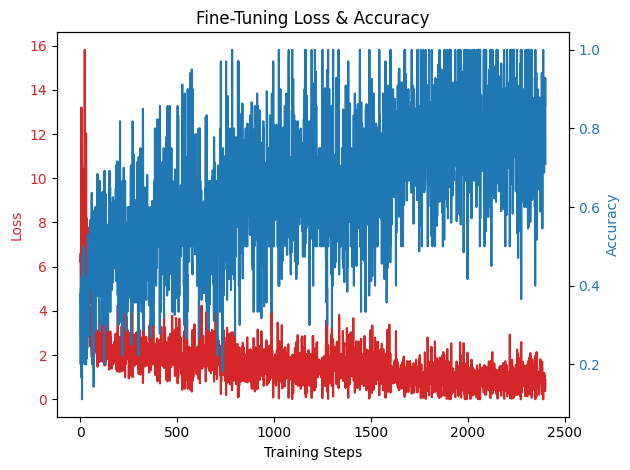

In [74]:
steps, losses, accuracies = extract_metrics(all_events)
plot_metrics(steps, losses, accuracies)

In [89]:
def generate_user_assistant_pairs(df, company_name, num_pairs=500):
    """
    Generate user-assistant message pairs filtered by a specific company name, iterating in reverse order.

    Parameters:
    - df (pd.DataFrame): The dataset containing tweets.
    - company_name (str): The name of the company (matches author_id for outbound messages).
    - num_pairs (int): The maximum number of pairs to generate.

    Returns:
    - List of tuples (user_message, assistant_response).
    """
    pairs = []
    
    # Iterate in reverse order (from last to first)
    for _, row in df[::-1].iterrows():
        if len(pairs) >= num_pairs:
            break  # Stop if we reached the required number of pairs
        
        if not row['inbound']:
            continue  # Skip outbound messages

        user_tweet = row
        response_tweets = df[df['in_response_to_tweet_id'] == user_tweet['tweet_id']]

        # Find responses from the specified company
        for _, response in response_tweets.iterrows():
            if len(pairs) >= num_pairs:
                break  # Stop if we reached the required number of pairs

            if not response['inbound'] and response['author_id'] == company_name:
                pairs.append((user_tweet['text'], response['text']))

    return pairs

In [90]:
pairs = generate_user_assistant_pairs(ds, company_name = "VirginTrains")

In [85]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze_sentiment(pairs):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_labels = []

    for user_message, assistant_message in pairs:
        user_sentiment = analyzer.polarity_scores(user_message)['compound']
        assistant_sentiment = analyzer.polarity_scores(assistant_message)['compound']

        # Simple logic to label based on sentiment score
        user_sentiment_label = 1 if user_sentiment < 0 else 0  # 0 = not rude, 1 = rude
        assistant_sentiment_label = 1 if assistant_sentiment < 0 else 0  # 0 = polite, 1 = impolite

        sentiment_labels.append((user_sentiment_label, assistant_sentiment_label))

    return sentiment_labels

In [86]:
sentiments = analyze_sentiment(pairs)

In [91]:
def count_sentiment_pairs(pairs):
    analyzer = SentimentIntensityAnalyzer()

    # Updated categories with negative and positive labels
    categorized_pairs = {
        'negative_user_positive_assistant': [],
        'negative_user_negative_assistant': [],
        'positive_user_negative_assistant': [],
        'positive_user_positive_assistant': []
    }

    for user_message, assistant_message in pairs:
        user_sentiment = analyzer.polarity_scores(user_message)['compound']
        assistant_sentiment = analyzer.polarity_scores(assistant_message)['compound']

        user_label = 1 if user_sentiment < 0 else 0  # 1 = negative, 0 = positive
        assistant_label = 1 if assistant_sentiment < 0 else 0  # 1 = negative, 0 = positive

        if user_label == 1 and assistant_label == 0:
            categorized_pairs['negative_user_positive_assistant'].append((user_message, assistant_message))
        elif user_label == 1 and assistant_label == 1:
            categorized_pairs['negative_user_negative_assistant'].append((user_message, assistant_message))
        elif user_label == 0 and assistant_label == 1:
            categorized_pairs['positive_user_negative_assistant'].append((user_message, assistant_message))
        elif user_label == 0 and assistant_label == 0:
            categorized_pairs['positive_user_positive_assistant'].append((user_message, assistant_message))

    return categorized_pairs

# Example usage
categorized_pairs = count_sentiment_pairs(pairs)

# You can print out the pairs to check the results
print(f"Negative user, Positive assistant pairs: {len(categorized_pairs['negative_user_positive_assistant'])}")
print(f"Negative user, Negative assistant pairs: {len(categorized_pairs['negative_user_negative_assistant'])}")
print(f"Positive user, Negative assistant pairs: {len(categorized_pairs['positive_user_negative_assistant'])}")
print(f"Positive user, Positive assistant pairs: {len(categorized_pairs['positive_user_positive_assistant'])}")

Negative user, Positive assistant pairs: 108
Negative user, Negative assistant pairs: 50
Positive user, Negative assistant pairs: 53
Positive user, Positive assistant pairs: 289


In [93]:
from pprint import pprint
pprint(categorized_pairs['positive_user_negative_assistant'][:5])

[('@VirginTrains morning BT who are you working with and when are you doing '
  'your xmas shopping',
  '@140066 Me and ^LC are on this morning. Pay day is tomorrow so mine shall '
  'be done then. You? ^BT'),
 ('@VirginTrains Is it true you guys are striking on December 22nd? I have '
  'booked tickets to travel on that day!!!! Will services actually run or will '
  'they be reduced??',
  '@288526 This is correct, we are working hard to keep majority of services '
  'running, but it will be a reduced service. ^BT'),
 ('Sat on @VirginTrains and the man doing the announcements is calling Milton '
  'Keynes “Milk and beans” and I want to disembark immediately',
  '@652561 Have you never been to Milk and Beans? Man-Chest-Hair? Glass-Cow? '
  "Alright I'll stop ^CB"),
 ('Stood in the full and cramped vestibule of an over subscribed 4hr '
  '@VirginTrains train to london\n'
  '\n'
  'Only one solution https://t.co/ioNehJkH6S',
  '@822148 Sorry to hear this, Christopher, which service are yo

In [94]:
evaluation_pairs = pairs

In [97]:
def get_model_response(prompt, system_message):
    try:
        response = client.chat.completions.create(
            model="ft:gpt-4o-mini-2024-07-18:smart-cloud::Az1rmOcz",
            messages=[{"role": "system", "content": system_message},
                      {"role": "user", "content": prompt}],
            max_tokens=150,
            temperature=0.2
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error while generating response: {e}")
        return ""

def add_model_responses_to_evaluation(evaluation_pairs, system_message):
    evaluation_data = []

    for user_message, assistant_message in evaluation_pairs:
        # Get model's response for the user message
        model_response = get_model_response(user_message, system_message)
        
        evaluation_data.append({
            "user_message": user_message,
            "assistant_message": assistant_message,
            "gpt_response": model_response
        })
    
    return evaluation_data

In [98]:
evaluation_with_responses = add_model_responses_to_evaluation(evaluation_pairs, system_message)

In [99]:
# Display the result
pprint(evaluation_with_responses[:5])

[{'assistant_message': "@524544 That's a Peak service. The 09:56 is the first "
                       'Off-Peak train from Crewe to London Euston ^CB',
  'gpt_response': 'This is an Off Peak service Emma MW',
  'user_message': '@VirginTrains Hope you are well? Does the 9.30am train from '
                  'Crewe to Euston class as peak or off-peak? Thanks'},
 {'assistant_message': '@823855 Which service are you on, Fiona? ^CB',
  'gpt_response': 'Sorry to hear this have you been able to get a seat since '
                  'boarding the train PA',
  'user_message': '£250 train fare for my round trip to London today (the same '
                  'trip I do every single week, a minimum once) and '
                  '@VirginTrains @107850 didn’t book me a seat. Nice one 👍🏽 '
                  '#robbers'},
 {'assistant_message': '@136417 Sorry to hear that James, did the the staff '
                       'should have made their way through, I will however '
                       'have 

In [100]:
def create_jsonl_from_pairs(evaluation_with_responses, filename='evaluation_pairs_with_gpt.jsonl'):
    with open(filename, 'w') as f:
        for entry in evaluation_with_responses:
            json.dump(entry, f)
            f.write('\n')

In [101]:
create_jsonl_from_pairs(evaluation_with_responses)

In [104]:
def evaluate_assistant_responses(evaluation_data, system_message="You are a customer support assistant."):
    results = []

    for item in evaluation_data:
        user_message = item["user_message"]
        assistant_message = item["assistant_message"]
        model_response = item["gpt_response"]

        # Create the prompt for the model
        prompt = f"""
        1. Evaluate the sentiment of the user's message. Respond with 'positive', 'negative', or 'neutral'.
        User message: '{user_message}'

        2. How did the original assistant respond (assistant_message)? Respond with 'offered help', 'showed empathy' or 'did not offer help or show empathy'.
        Assistant's response: '{assistant_message}'

        3. How did your assistant respond (model_response)? Respond with 'offered help', 'showed empathy' or 'did not offer help or show empathy'.
        Assistant's response: '{model_response}'

        Please format your answer like this:
        sentiment, assistant_response, fine_tuned_response
        For example: "positive, offered help, offered help"
        """

        model_eval_response = get_model_response(prompt, system_message)
        #print(f"Model response: {model_eval_response}")

        # Parse the model's response by splitting on commas
        try:
            parts = model_eval_response.strip().split(',')
            #print(parts)

            # Ensure we have exactly three parts (sentiment, assistant response, and fine-tuned response)
            if len(parts) == 3:
                sentiment = parts[0].strip()  # Sentiment (positive/negative/neutral)
                assistant_response = parts[1].strip()  # Assistant's response (offered help, showed empathy, etc.)
                fine_tuned_response = parts[2].strip()  # Fine-tuned assistant's response (offered help, showed empathy, etc.)
            else:
                sentiment, assistant_response, fine_tuned_response = "Error", "Error", "Error"

        except Exception as e:
            print(f"Error while parsing response: {e}")
            sentiment, assistant_response, fine_tuned_response = "Error", "Error", "Error"

        results.append({
            "user_message": user_message,
            "assistant_message": assistant_message,
            "gpt_response": model_response,
            "user_sentiment": sentiment,
            "assistant_response": assistant_response,
            "fine_tuned_response": fine_tuned_response
        })

    return results

In [105]:
evaluated_test_set = evaluate_assistant_responses(evaluation_with_responses)

In [107]:
create_jsonl_from_pairs(evaluated_test_set, 'intent_evaluation.jsonl')

In [109]:
def filter_and_count_no_help(evaluated_test_set):
    # Filter the evaluation data where model_response is "did not offer help or show empathy"
    no_help_responses = [item for item in evaluated_test_set if item['fine_tuned_response'] == 'did not offer help or show empathy']

    # Print all such responses
    for response in no_help_responses:
        print(f"User Message: {response['user_message']}")
        print(f"Assistant Message: {response['assistant_message']}")
        print(f"Model Response: {response['gpt_response']}")
        print('-' * 50)

    # Count the number of such responses
    no_help_count = len(no_help_responses)

    print(f"\nTotal number of responses where model did not offer help or show empathy: {no_help_count}")
    return no_help_count

In [110]:
no_help_count = filter_and_count_no_help(evaluated_test_set)

User Message: @VirginTrains wifi not working Preston to Euston awesome
Assistant Message: @269472 Which time service are you on today? ^LC
Model Response: This is one for to look at PA
--------------------------------------------------
User Message: @VirginTrains dear virgin trains west coast isn’t about time your first and standard class got updated looks little out off date
Assistant Message: @353530 Thanks for your feedback, Henry. We'll pass this onto our makeover department ^MM https://t.co/ThLnSQn8O3
Model Response: This is one for to look at PA
--------------------------------------------------
User Message: The ticket man on this train is sound - a frighteningly good service on this cold Halloween evening @VirginTrains 

⭐️⭐️⭐️⭐️⭐️
Assistant Message: @822469 Sounds splendid this evening! Great to hear ^CB
Model Response: Thanks for your feedback well pass this on MM
--------------------------------------------------
User Message: I think @VirginTrains makes their trains unbeara

In [111]:
print(no_help_count)

134
